In [69]:
import torch
from torch import optim, nn
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tqdm.notebook import tqdm
import os
from PIL import Image
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import shutil
from tqdm.notebook import tqdm

# Steps

- Check for corrupted images
- Plot sample of those images
- Check for completely black or white images
- Remove those images from the sample
- Check that exist similar images
- Get our model for extraction of the features
- Modify the model to return those features (no training here)
- Create a feature matrix
- Using KMeans to cluster those images based on the features
    - Analyse sillhouette
    - Analyse elbow distortion metric
- Final choice of the model
- Analyse our results
- Sampling from each cluster

# Variáveis

In [2]:
PATH_DATA = "./data/raw/histopathologic-cancer-detection/train_v2/"

# Checks de Sanidade

In [3]:
# check file types
files = os.listdir(PATH_DATA)
file_types = [file.split(".")[-1] for file in files]
set(file_types)

{'tif'}

In [4]:
# try importing tif images
error = []

for file in files:
    path_file = PATH_DATA + file
    try:
        Image.open(path_file)
    except:
        error.append(file)

len(error)

0

In [5]:
# check images size
width_lst = []
height_lst = []
image_lst = []
mode_lst = []

for file in files:
    path_file = PATH_DATA + file
    img = Image.open(path_file)
    width, height = img.size
    mode = img.mode

    mode_lst.append(mode)
    width_lst.append(width)
    height_lst.append(height)
    image_lst.append(file)

width_set = set(width_lst)
height_set = set(height_lst)
mode_set = set(mode_lst)
width_set, height_set, mode

({96}, {96}, 'RGB')

Vimos aqui que todas as imagens conseguem ser importadas para o nosso ambiente e que no meu diretório temos apenas imagens `.tif`, 96x96 e coloridas!

# Plotando amostra dos nossos dados

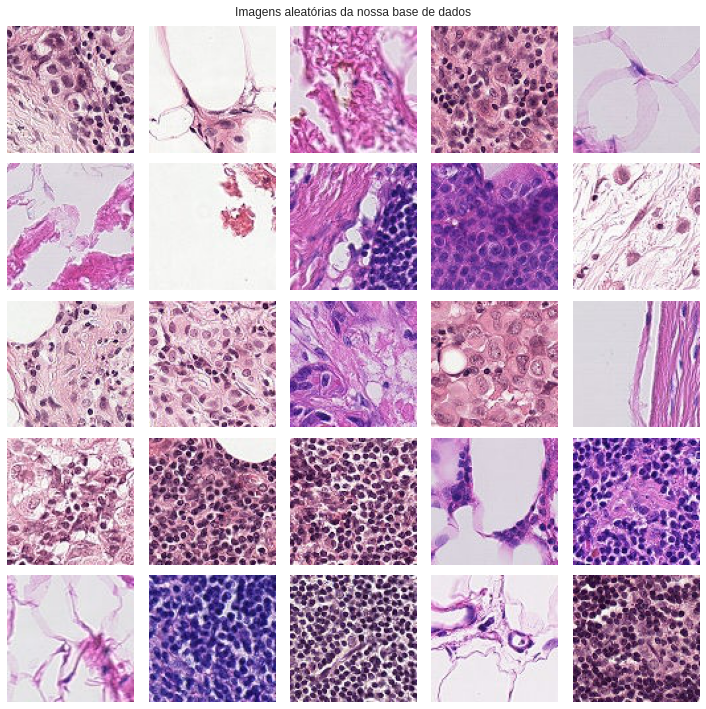

In [6]:
# visualizing our images
files = os.listdir(PATH_DATA)
# np.random.seed(11)
files_sample = np.random.choice(files, 25)

# creating a 'figure'
plt.figure(figsize=(10, 10))
plt.suptitle("Imagens aleatórias da nossa base de dados")
for i, file in enumerate(files_sample):
    image_path = PATH_DATA + file
    img = Image.open(image_path)
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


- Temos imagens muito claras
- Temos imagens muito escuras
- Temos imagens muito parecidas

# Checando for imagens muito brancas e muito escuras

Uma imagem branca possui valores de pixels mais próximos do 255 e imagens escuras possuem pixels mais próximos do 0. Com base nisso, nós vamos checar como estão distribuídos esses tipos de imagens no nosso dataset.

Essas imagens mais escuras e claras podem ser defeitos de como a coleta foi feita e é muito importante verificar por eles no nosso dataset, para garantir a qualidade do dado utilizado.

In [14]:
# thresholds
dark_th = 55 / 255
bright_th = 250 / 255

# to save fales on each situation
too_dark_idxs = []
too_bright_idxs = []

files = os.listdir(PATH_DATA)

for i, file in tqdm(enumerate(files), "Computing..."):
    file_path = PATH_DATA + file
    image_array = imread(file_path).reshape(-1, 3)
    mean_px_value = image_array.mean()

    # mean pixels compared to the threshold
    if (mean_px_value / 255) < dark_th:
        too_dark_idxs.append(file)
    
    if (mean_px_value.mean() / 255) > bright_th:
        too_bright_idxs.append(file)

print("Too dark images length: {}".format(len(too_dark_idxs)))
print("Too bright images length: {}".format(len(too_bright_idxs)))


Computing...: 0it [00:00, ?it/s]

Too dark images length: 11
Too bright images length: 7


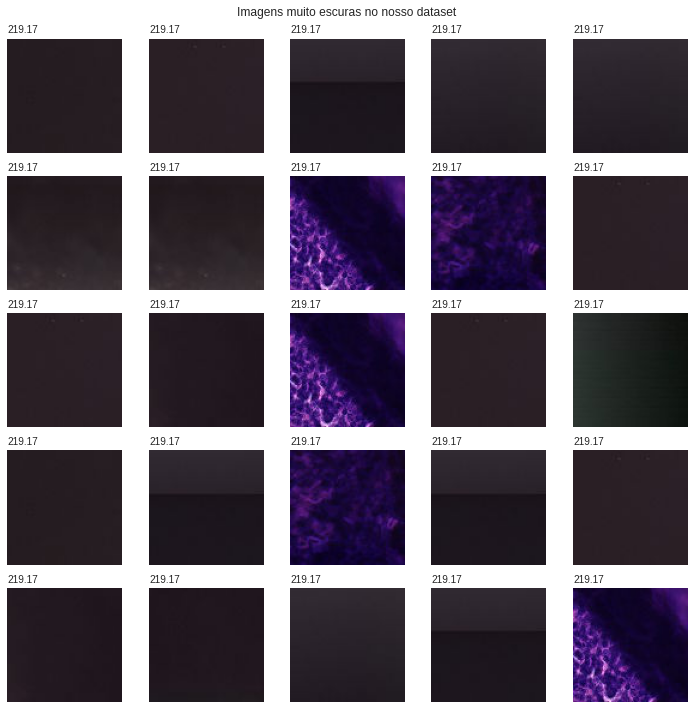

In [15]:
# plotting too black
# pick just 25 items
files_sample = np.random.choice(too_dark_idxs, 25)

# creating a 'figure'
plt.figure(figsize=(10, 10))
plt.suptitle("Imagens muito escuras no nosso dataset")
for i, file in enumerate(files_sample):
    image_path = PATH_DATA + file
    img = Image.open(image_path)
    image_array_mean = np.array(img).mean()
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, round(image_array.mean(), 2))
    plt.axis('off')

plt.tight_layout()
plt.show()

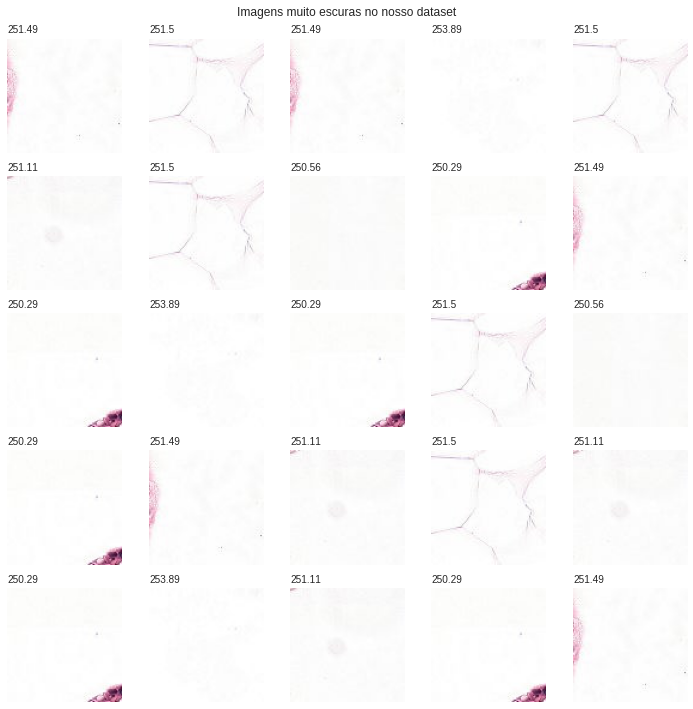

In [16]:
# plotting too black
# pick just 25 items
files_sample = np.random.choice(too_bright_idxs, 25)

# creating a 'figure'
plt.figure(figsize=(10, 10))
plt.suptitle("Imagens muito escuras no nosso dataset")
for i, file in enumerate(files_sample):
    image_path = PATH_DATA + file
    img = Image.open(image_path)
    image_array_mean = np.array(img).mean()
    plt.subplot(5, 5, i+1)
    plt.text(0, -5, round(image_array_mean, 2))
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Removendo imagens da amostra

- Criar um diretório caso não existaa para armazenar essas imagens
- Mover as imagens do nosso diretório para a pasta criada

In [28]:
# creating our dir
out_path = "./data/raw/outliers/"
files = too_dark_idxs + too_bright_idxs

# check if exist
outliers_is_dir = os.path.isdir(out_path)

# create
if not outliers_is_dir:
    os.makedirs(out_path)

# move
for file in files:
    file_path = PATH_DATA + file
    try:
        shutil.move(file_path, out_path)
    except:
        print("Essa imagem, provavelmente já foi copiada!")



Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!
Essa imagem, provavelmente já foi copiada!


# Instanciando o modelo que vamos usar para o *feature extraction*

Vamos utilizar aqui o modelo VGG16 como nosso extrator de features. Mas, basicamente qualquer outro modelo baseado em convoluções (CNNs) poderia ser utilizado para essa task. Pode até ser uma experimentação futura, iterar sobre diferentes modelos e comparar qual se sai melhor.

In [29]:
model = models.vgg16(weights=True)

/home/luba/.local/share/virtualenvs/ds-as-a-software-iy38ZIEu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# inspect our architecture
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
list(model.features)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

# <span style="color:orange">Modificando o modelo para o nosso caso</span>.

In [50]:
class FeatureExtractor(nn.Module):
    def __init__(self, model) -> None:
        super().__init__()
        # extract vgg16 feature layers
        self.features = model.features
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = model.classifier[0]

    def forward(self, x):
        out = nn.Sequential(self.features, self.pooling, self.flatten, self.fc)
        out = out(x)
        return out


In [51]:
feature_extractor_model = FeatureExtractor(model)

In [52]:
# check if there is a gpu installed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
feature_extractor_model = feature_extractor_model.to(device)

# <span style="color:orange">Criando nossa *feature matrix*</span>.

In [53]:
# basic transformation
transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.Resize(448),
    transforms.ToTensor()
])

features = []

files = os.listdir("./data/raw/histopathologic-cancer-detection/train_v2")

for file in tqdm(files):
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + file
    img = Image.open(img_path)
    img = transform(img)
    # vgg16 expect an image with this size
    img = img.reshape(1, 3, 448, 448)
    # put our tensor on the correct device
    img = img.to(device)
    # no grad because we are not training nothing
    with torch.no_grad():
        feature = feature_extractor_model(img)
        features.append(feature.cpu().detach().numpy().reshape(-1))

feature_matrix = np.array(features)

  0%|          | 0/9389 [00:00<?, ?it/s]

# <span style="color:orange">Utilizando KMeans para agrupar (clusters) imagens</span>. 

Agora, como nós temos uma matrix de features, nós podemos utiliza-la para agrupar imagens em clusters. Nesse exemplos o KMeans será utilizado para clusterizar, mas também fique a vontade para utilizar qualquer outro algorítimo. Abaixo deixo a documentação do `sklearn` com os métodos disponíveis para clusterizar:

- TODO

In [61]:
np.arange(2, 12)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

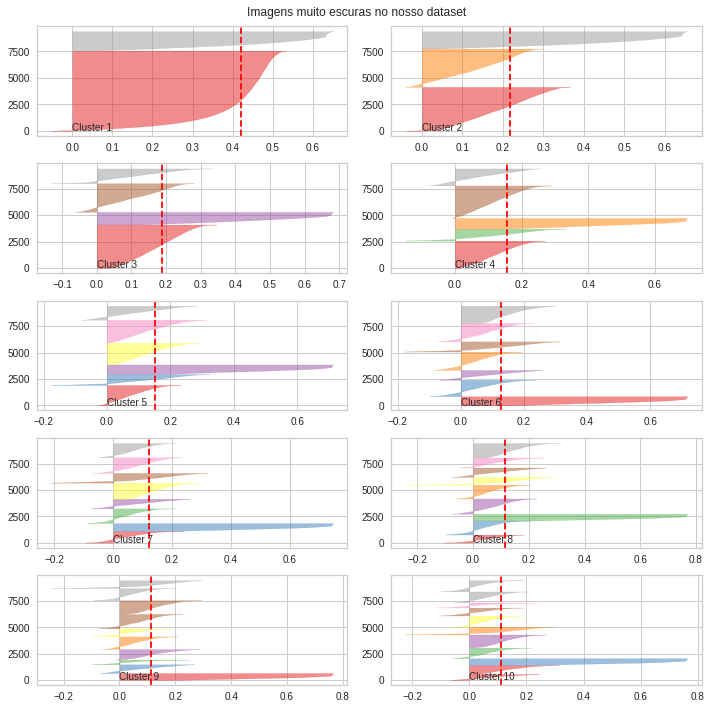

In [64]:
clusters_to_test = np.arange(2, 12)
# clusters_to_test = [2]

# creating a 'figure'
plt.figure(figsize=(10, 10))
plt.suptitle("Imagens muito escuras no nosso dataset")
for i, cluster in enumerate(clusters_to_test, start=1):
    km = KMeans(n_clusters=cluster, init="k-means++", n_init=10, max_iter=100, random_state=42)
    plt.subplot(5, 2, i)
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(feature_matrix)    
    plt.text(0, 5, f"Cluster {i}")

plt.tight_layout()
plt.show()

- Avaliar quantos clusters devemos escolher, mesclando o silhouette, elbow e plotando.

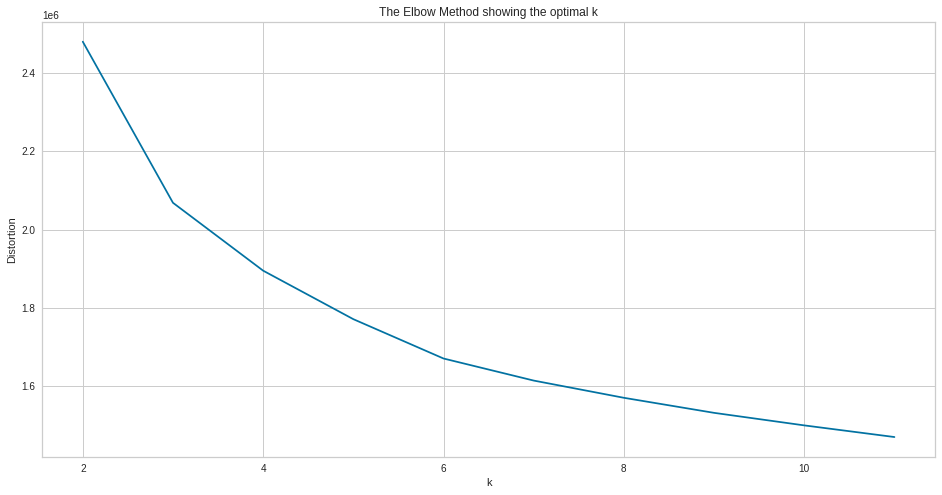

In [66]:
distortions = []
K = np.arange(2, 12)

for k in K:
    kmeansModel = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    kmeansModel.fit(feature_matrix)
    distortions.append(kmeansModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# <span style="color:orange">Finalizing our clustering</span>.

In [67]:
model = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
model.fit(feature_matrix)
labels = model.labels_

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=4,
                                      random_state=42))

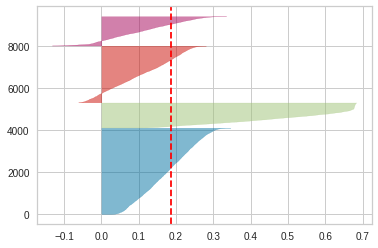

In [68]:
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(feature_matrix)

# <span style="color:orange">Visualizing each cluster</span>. 

In [70]:
feat_df = pd.DataFrame(feature_matrix)
feat_df["labels"] = model.labels_
feat_df["files"] = files

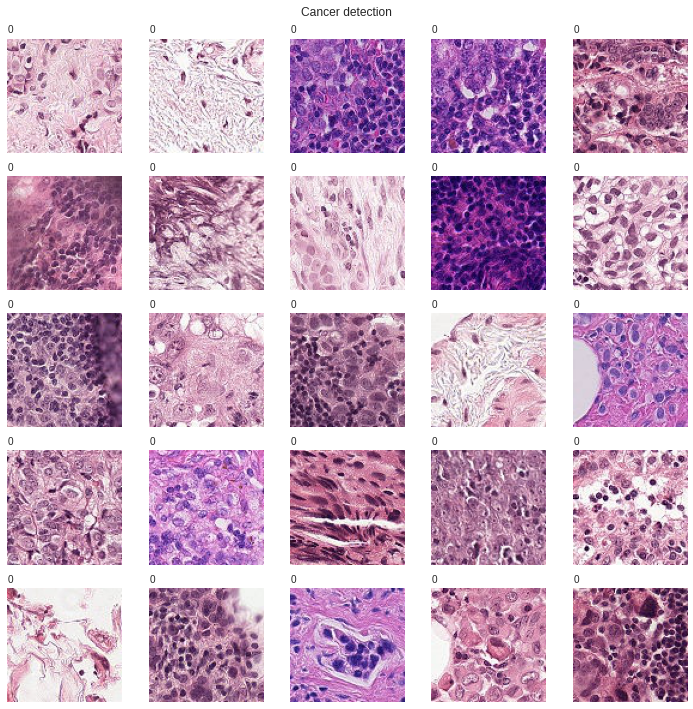

In [95]:
plt.figure(figsize=(10, 10))
plt.suptitle("Cancer detection")
feat_sample = feat_df[feat_df["labels"] == 0].sample(n=25).reset_index()
for i, row in feat_sample.iterrows():
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + row.files
    img = Image.open(img_path)
    label = row.labels
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, label)
    plt.axis('off')

plt.tight_layout()
plt.show()

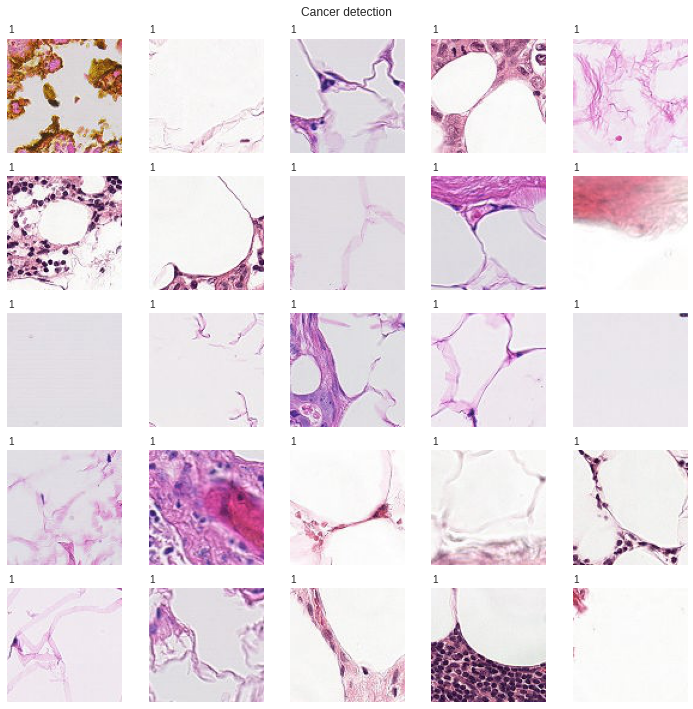

In [92]:
plt.figure(figsize=(10, 10))
plt.suptitle("Cancer detection")
feat_sample = feat_df[feat_df["labels"] == 1].sample(n=25).reset_index()
for i, row in feat_sample.iterrows():
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + row.files
    img = Image.open(img_path)
    label = row.labels
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, label)
    plt.axis('off')

plt.tight_layout()
plt.show()

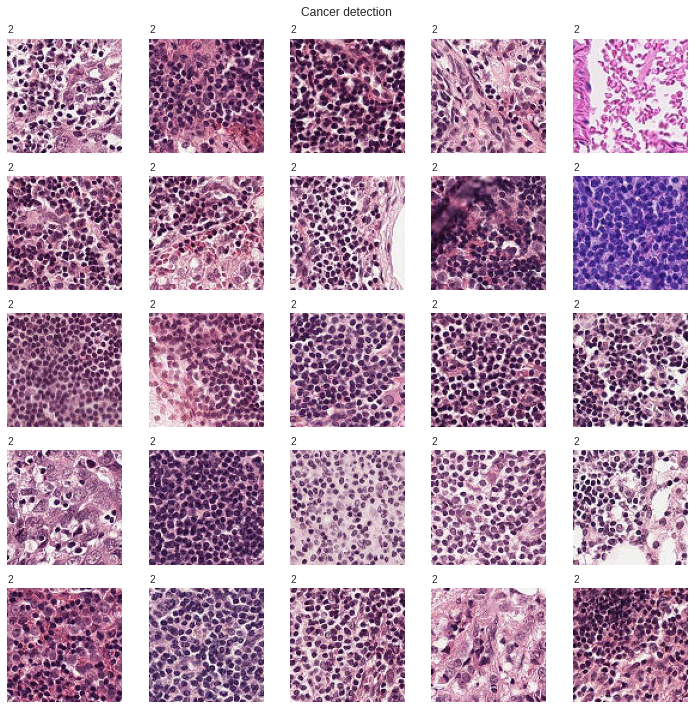

In [93]:
plt.figure(figsize=(10, 10))
plt.suptitle("Cancer detection")
feat_sample = feat_df[feat_df["labels"] == 2].sample(n=25).reset_index()
for i, row in feat_sample.iterrows():
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + row.files
    img = Image.open(img_path)
    label = row.labels
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, label)
    plt.axis('off')

plt.tight_layout()
plt.show()

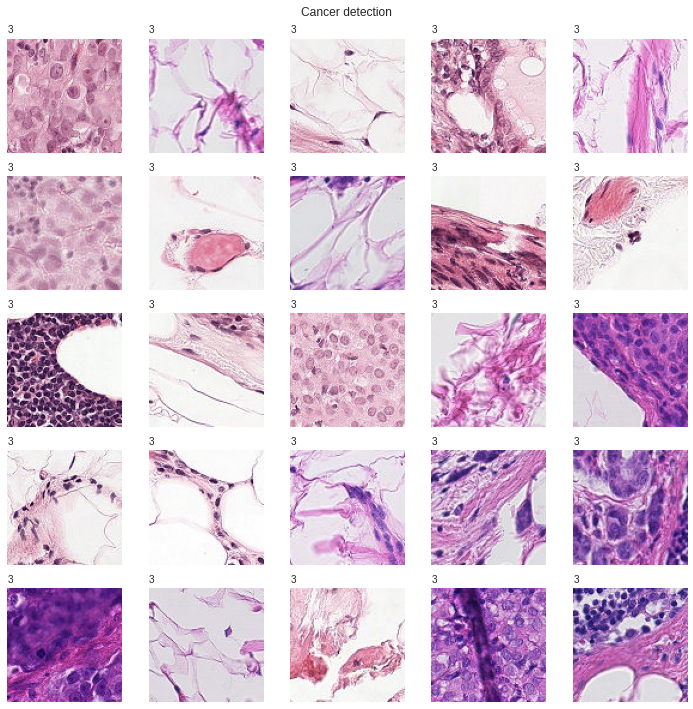

In [94]:
plt.figure(figsize=(10, 10))
plt.suptitle("Cancer detection")
feat_sample = feat_df[feat_df["labels"] == 3].sample(n=25).reset_index()
for i, row in feat_sample.iterrows():
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + row.files
    img = Image.open(img_path)
    label = row.labels
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# <span style="color:orange">Sampling each cluster</span>.

Vamos coletar de cada cluster 250 imagens aleatoriamente para garantir uma diversidade na amostra que vai ser utilizada no treinamento do modelo no próximo vídeo. 

In [104]:
clusters_files = feat_df[["labels", "files"]]
cluster_0 = clusters_files[clusters_files["labels"] == 0].sample(n=250)
cluster_1 = clusters_files[clusters_files["labels"] == 1].sample(n=250)
cluster_2 = clusters_files[clusters_files["labels"] == 2].sample(n=250)
cluster_3 = clusters_files[clusters_files["labels"] == 3].sample(n=250)

final_sample = pd.concat([cluster_0, cluster_1, cluster_2, cluster_3]).sample(frac=1).reset_index(drop=True)
final_sample.shape

(1000, 2)

In [106]:
# export our dataframe with 1000 samples to use
final_sample.to_csv("./data/raw/histopathologic-cancer-detection/sample_one_thousand.csv", index=False)